## Librerias

In [4]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)
library(hnp)

ERROR: Error in library(hnp): there is no package called ‘hnp’


## Data

In [ ]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [ ]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Grupo_Edad,valor,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41-63,64667906,2,1834,2558114,10,1279057
2,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,76728037,2,1203,4883644,7,2441822
3,1997,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41-63,121930553,2,3077,4238816,16,2119408
4,1998,AZUL,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,130833256,2,2791,8213167,16,4106584
5,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,101517338,2,2410,8014069,13,4007035
6,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,180459141,4,4223,6450375,23,1612594


In [ ]:
summary(data$suma_pagos)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  148662  1914583  4185008  7373264  9182684 68223671 

## Seleccion de variables

In [ ]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Grupo_Edad")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2012 
Variable: Color - Categoría de referencia: PLATA 
Variable: Carroceria - Categoría de referencia: HATCHBACK 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Grupo_Edad - Categoría de referencia: 41-63 
'data.frame':	258 obs. of  14 variables:
 $ Modelo          : Factor w/ 18 levels "2012","1993",..: 2 2 3 4 4 4 4 4 4 5 ...
 $ Color           : Factor w/ 19 levels "PLATA","AMARILLO",..: 16 16 5 3 5 5 9 16 18 5 ...
 $ Carroceria      : Factor w/ 10 levels "HATCHBACK","BUS-BUSETA",..: 8 8 8 8 8 8 10 8 8 8 ...
 $ CLASE_FASECOLDA : Factor w/ 7 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 1 1 5 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        : Factor w/ 3 levels "Particular","Publi

## FRECUENCIA 

In [ ]:
# Modelo completo de frecuencia con offset
modelo_freq_completo <- glm(
  n_siniestros ~ log(valor) + Color + Carroceria + CLASE_FASECOLDA + 
                 TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad + 
                 offset(log(exposicion_total)),
  family = quasipoisson(),
  data = data
)

# Modelo nulo de frecuencia
modelo_freq_nulo <- glm(
  n_siniestros ~ offset(log(exposicion_total)),
  family = quasipoisson(),
  data = data
)

# Selección de variables usando stepwise
modelo_frecuencia_final <- step(
  modelo_freq_completo,
  scope = list(lower = modelo_freq_nulo, upper = modelo_freq_completo),
  direction = "both",
  trace = TRUE
)

# Resumen del modelo final
summary(modelo_frecuencia_final)

ERROR: Error in parse(text = x, srcfile = src): <text>:6:19: unexpected '='
5:                  offset(log(exposicion_total)),
6:   family = family =
                     ^


## Evaluación

In [ ]:
# Verificar sobredispersión
dispersion <- sum(residuals(modelo_frecuencia_final, type = "pearson")^2) / modelo_frecuencia_final$df.residual
cat("Parámetro de dispersión:", dispersion, "\n")

if (dispersion > 1.5) {
  cat("ADVERTENCIA: Hay evidencia de sobredispersión. Considerar modelo quasi-Poisson o binomial negativa.\n")
} else {
  cat("La dispersión parece apropiada para el modelo Poisson.\n")
}

Parámetro de dispersión: 0.3902367 
La dispersión parece apropiada para el modelo Poisson.


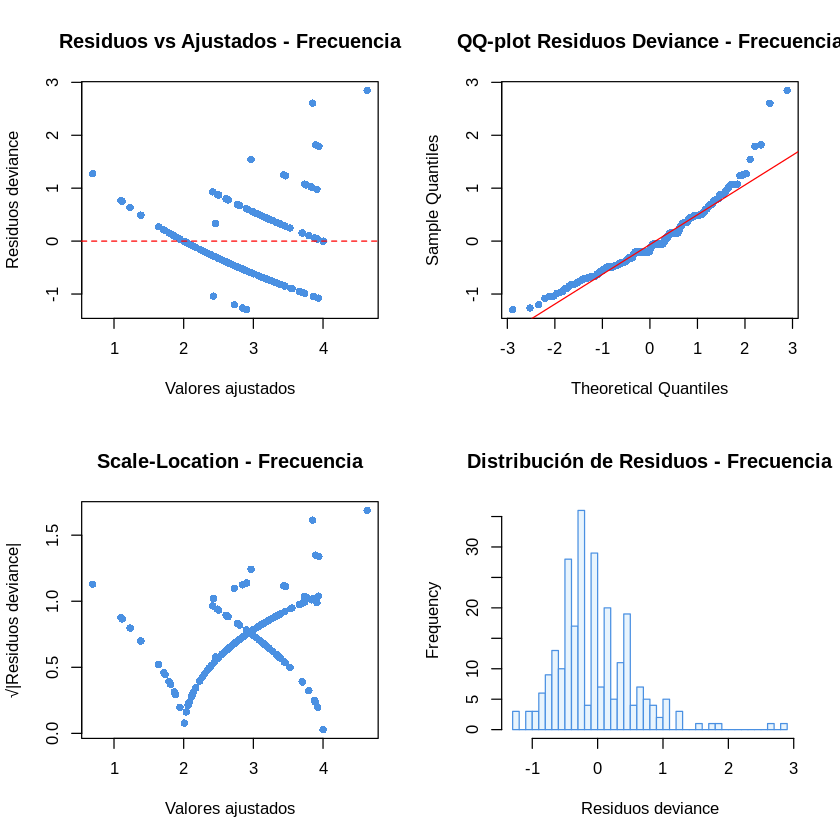

In [ ]:
# Gráficos diagnósticos para el modelo de frecuencia
residuos_deviance <- residuals(modelo_frecuencia_final, type = "deviance")
residuos_pearson <- residuals(modelo_frecuencia_final, type = "pearson")
valores_ajustados <- fitted(modelo_frecuencia_final)

# Panel de diagnósticos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados - Frecuencia",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance - Frecuencia",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location - Frecuencia",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos - Frecuencia",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

In [ ]:
# Envelope plot para el modelo de frecuencia
envelope_frecuencia <- hnp(modelo_frecuencia_final,
                          halfnormal = TRUE,
                          plot = TRUE,
                          main = "Envelope Plot - Modelo Frecuencia",
                          col = "#4A90E2")

Poisson model 


ERROR: Error: no valid set of coefficients has been found: please supply starting values


## Diagnóstico del ajuste del modelo

In [ ]:
# Análisis detallado del problema
cat("=== DIAGNÓSTICO DEL MODELO ===\n")
cat("Dispersión:", dispersion, "\n")
cat("Deviance/df:", deviance(modelo_frecuencia_final)/modelo_frecuencia_final$df.residual, "\n")

# Verificar distribución de la variable respuesta
cat("\n=== DISTRIBUCIÓN DE n_siniestros ===\n")
table(data$n_siniestros)

# Verificar ceros excesivos
prop_ceros <- sum(data$n_siniestros == 0) / nrow(data)
cat("\nProp. de ceros:", round(prop_ceros, 3), "\n")

# Verificar valores ajustados vs observados
mu_hat <- fitted(modelo_frecuencia_final)
cat("Rango valores ajustados:", round(range(mu_hat), 3), "\n")
cat("Media n_siniestros:", round(mean(data$n_siniestros), 3), "\n")

=== DIAGNÓSTICO DEL MODELO ===


Dispersión: 0.383571 
Deviance/df: 0.3743599 

=== DISTRIBUCIÓN DE n_siniestros ===



  1   2   3   4   6   8  10  12 
  4 188   1  52   9   2   1   1 


Prop. de ceros: 0 
Rango valores ajustados: 0.85 8.705 
Media n_siniestros: 2.647 


## Modelos alternativos

In [ ]:
# 1. Binomial Negativa (para sobredispersión)
library(MASS)

# Crear fórmula segura excluyendo variables con un solo nivel
if(exists("vars_problema") && length(vars_problema) > 0) {
  vars_validas_nb <- setdiff(c("valor", "Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                               "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Grupo_Edad"), vars_problema)
} else {
  vars_validas_nb <- c("valor", "Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                       "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Grupo_Edad")
}

formula_nb_str <- paste("n_siniestros ~", paste(vars_validas_nb, collapse = " + "), 
                        "+ offset(log(exposicion_total))")

cat("Fórmula Binomial Negativa:", formula_nb_str, "\n")

modelo_nb <- glm.nb(
  as.formula(formula_nb_str),
  data = data
)

# Selección stepwise para binomial negativa
modelo_nb_step <- stepAIC(modelo_nb, direction = "both", trace = FALSE)

cat("\n=== BINOMIAL NEGATIVA ===\n")
cat("Theta:", modelo_nb_step$theta, "\n")
cat("AIC:", AIC(modelo_nb_step), "\n")
summary(modelo_nb_step)

Fórmula Binomial Negativa: n_siniestros ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad + offset(log(exposicion_total)) 

=== BINOMIAL NEGATIVA ===
Theta: 60098.1 
AIC: 857.0664 



Call:
glm.nb(formula = n_siniestros ~ valor + CLASE_FASECOLDA + Sexo_Aseg + 
    offset(log(exposicion_total)), data = data, init.theta = 60098.10026, 
    link = log)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.88269  -0.37735   0.07086   0.46636   2.28076  

Coefficients:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                            -6.709e+00  8.139e-02 -82.435  < 2e-16
valor                                  -4.504e-10  7.532e-11  -5.980 2.23e-09
CLASE_FASECOLDAAUTOMOVIL TAXI          -2.886e-01  1.119e-01  -2.578  0.00993
CLASE_FASECOLDABUS / BUSETA / MICROBUS  6.232e-01  5.100e-01   1.222  0.22172
CLASE_FASECOLDACAMION                  -2.611e-02  7.097e-01  -0.037  0.97065
CLASE_FASECOLDACAMIONETA                2.427e-01  1.472e-01   1.649  0.09922
CLASE_FASECOLDACAMPERO                  2.015e-01  1.548e-01   1.302  0.19308
CLASE_FASECOLDAMICROBUS                 7.212e-01  5.077e-01   1.420

In [ ]:
# 2. Modelo Zero-Inflated Poisson (si hay exceso de ceros)
if(prop_ceros > 0.5) {
  library(pscl)
  
  # Usar fórmula segura
  formula_zip_str <- paste("n_siniestros ~", paste(vars_validas_nb, collapse = " + "), 
                           "+ offset(log(exposicion_total)) | 1")
  
  cat("Fórmula Zero-Inflated:", formula_zip_str, "\n")
  
  modelo_zip <- zeroinfl(
    as.formula(formula_zip_str),
    data = data,
    dist = "poisson"
  )
  
  cat("\n=== ZERO-INFLATED POISSON ===\n")
  cat("AIC:", AIC(modelo_zip), "\n")
  summary(modelo_zip)
} else {
  cat("\nProp. de ceros (", round(prop_ceros, 3), ") no justifica modelo zero-inflated\n")
}


Prop. de ceros ( 0 ) no justifica modelo zero-inflated


## Modelo alternativo si hay sobredispersión

In [ ]:
# Si hay sobredispersión, usar quasi-Poisson
modelo_freq_quasi <- glm(
  formula(modelo_frecuencia_final),
  family = quasipoisson(link = "log"),
  data = data
)

# Comparar dispersión
cat("Dispersión Poisson:", dispersion, "\n")
cat("Dispersión quasi-Poisson:", summary(modelo_freq_quasi)$dispersion, "\n")

# Mostrar resumen del modelo quasi-Poisson
summary(modelo_freq_quasi)

Dispersión Poisson: 0.383571 
Dispersión quasi-Poisson: 0.3835723 



Call:
glm(formula = formula(modelo_frecuencia_final), family = quasipoisson(link = "log"), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7462  -0.3741   0.0282   0.4066   2.1629  

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                             0.17707    0.55949   0.316 0.751902    
log(valor)                             -0.36052    0.02790 -12.921  < 2e-16 ***
CLASE_FASECOLDAAUTOMOVIL TAXI          -0.25180    0.06926  -3.636 0.000337 ***
CLASE_FASECOLDABUS / BUSETA / MICROBUS  0.59879    0.31394   1.907 0.057624 .  
CLASE_FASECOLDACAMION                   0.11327    0.43979   0.258 0.796955    
CLASE_FASECOLDACAMIONETA                0.31445    0.09171   3.429 0.000709 ***
CLASE_FASECOLDACAMPERO                  0.28998    0.09621   3.014 0.002845 ** 
CLASE_FASECOLDAMICROBUS                 0.74740    0.31356   2.384 0.017895 *  
Sexo_AsegF                             -0

### Evaluación del modelo quasi-Poisson

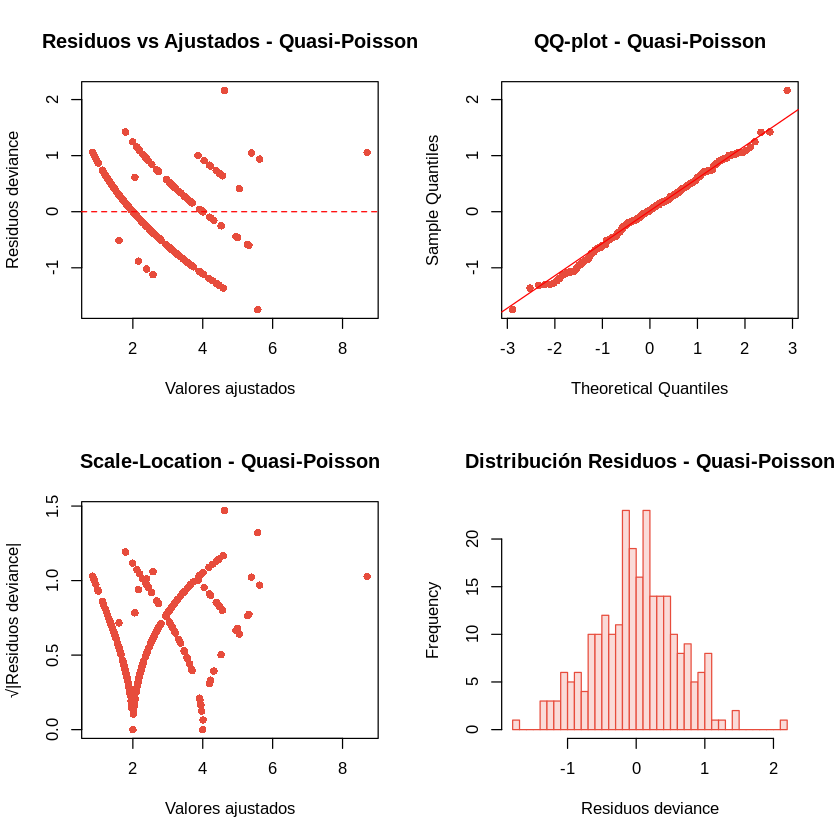

In [ ]:
# Gráficos diagnósticos para el modelo quasi-Poisson
residuos_quasi_deviance <- residuals(modelo_freq_quasi, type = "deviance")
residuos_quasi_pearson <- residuals(modelo_freq_quasi, type = "pearson")
valores_ajustados_quasi <- fitted(modelo_freq_quasi)

# Panel de diagnósticos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados_quasi, residuos_quasi_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados - Quasi-Poisson",
     pch = 16, col = "#E74C3C")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_quasi_deviance, 
       main = "QQ-plot - Quasi-Poisson",
       pch = 16, col = "#E74C3C")
qqline(residuos_quasi_deviance, col = "red")

# Scale-Location
plot(valores_ajustados_quasi, sqrt(abs(residuos_quasi_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location - Quasi-Poisson",
     pch = 16, col = "#E74C3C")

# Histograma de residuos
hist(residuos_quasi_deviance, 
     breaks = 30,
     main = "Distribución Residuos - Quasi-Poisson",
     xlab = "Residuos deviance",
     col = "#FADBD8",
     border = "#E74C3C")

par(mfrow = c(1, 1))

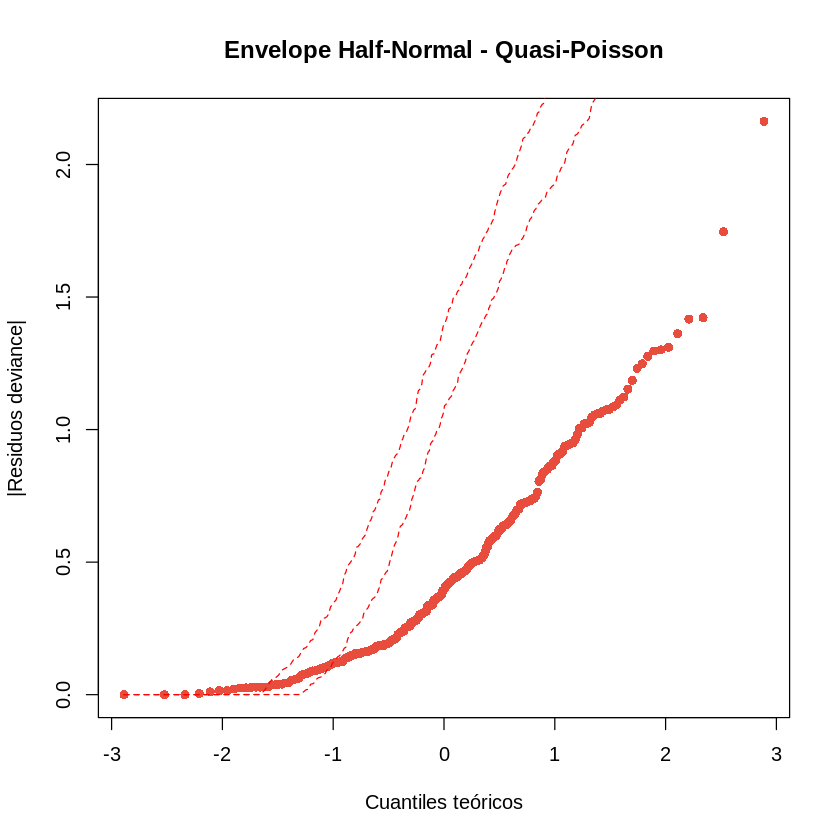

In [ ]:
# Envelope plot manual para modelo quasi-Poisson
envelope_quasipoisson_manual <- function(modelo, nsim = 99, conf = 0.95) {
  n <- length(residuals(modelo))
  
  # Extraer información del modelo
  y <- modelo$y
  mu <- fitted(modelo)
  phi <- summary(modelo)$dispersion
  
  # Matriz para almacenar residuos simulados
  res_sim <- matrix(NA, n, nsim)
  
  # Simular datos y calcular residuos
  set.seed(123)
  for(i in 1:nsim) {
    # Simular respuestas desde quasi-Poisson (usando Poisson con ajuste de varianza)
    y_sim <- rpois(n, lambda = mu * phi) / phi
    
    # Ajustar modelo (con manejo de errores)
    tryCatch({
      # Crear dataframe temporal con los datos simulados
      data_temp <- modelo$data
      data_temp$y_sim <- y_sim
      
      # Ajustar modelo quasi-Poisson
      modelo_sim <- glm(y_sim ~ ., 
                       data = data_temp[, !names(data_temp) %in% c("n_siniestros")],
                       family = quasipoisson(link = "log"),
                       offset = log(data_temp$exposicion_total))
      
      res_sim[,i] <- sort(abs(residuals(modelo_sim, type = "deviance")))
    }, error = function(e) {
      res_sim[,i] <- NA
    })
  }
  
  # Calcular bandas de confianza
  alpha <- (1 - conf) / 2
  lower <- apply(res_sim, 1, quantile, probs = alpha, na.rm = TRUE)
  upper <- apply(res_sim, 1, quantile, probs = 1-alpha, na.rm = TRUE)
  
  # Crear gráfico
  res_obs <- sort(abs(residuals(modelo, type = "deviance")))
  valores_teoricos <- qnorm((1:n - 0.5) / n)
  
  plot(valores_teoricos, res_obs,
       pch = 16, col = "#E74C3C",
       xlab = "Cuantiles teóricos",
       ylab = "|Residuos deviance|",
       main = "Envelope Half-Normal - Quasi-Poisson")
  
  lines(valores_teoricos, lower, col = "red", lty = 2)
  lines(valores_teoricos, upper, col = "red", lty = 2)
  
  # Retornar información
  invisible(list(
    observed = res_obs,
    lower = lower,
    upper = upper,
    theoretical = valores_teoricos
  ))
}

# Aplicar la función envelope manual
envelope_quasi_manual <- envelope_quasipoisson_manual(modelo_freq_quasi)

In [ ]:
# Intentar usar hnp con modelo quasi-Poisson (puede funcionar o no)
tryCatch({
  envelope_quasi_hnp <- hnp(modelo_freq_quasi,
                           halfnormal = TRUE,
                           plot = TRUE,
                           main = "Envelope Plot hnp - Quasi-Poisson",
                           col = "#E74C3C")
}, error = function(e) {
  cat("Error con hnp para quasi-Poisson:", e$message, "\n")
  cat("Usando función manual desarrollada arriba.\n")
})

Quasi-Poisson model 
Error con hnp para quasi-Poisson: attempt to set an attribute on NULL 
Usando función manual desarrollada arriba.
